In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP#,MLP2
from utils.interactions import rollout_traj_env_policy
from models.model_training import ModelTrainer
from models.models import NeuralEulerODE

2024-11-29 10:57:59.104642: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [4]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

In [5]:
@eqx.filter_jit
def reset(node,rng):
    obs, _ = motor_env.reset(motor_env.env_properties, rng)  #
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

In [6]:
@eqx.filter_jit
def featurize(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])#jnp.concatenate([obs[0:2],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

In [7]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,4:6])**2,axis=1))#be aware of idx if changing featurize
    return loss

In [8]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [9]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2],key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [10]:
@eqx.filter_jit
def motor_env_dat_gen_sin(env,reset_env, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset_env(env,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset_env(env,subkey)  
    return init_obs, ref_obs, rng

In [11]:
data_batch_size=100
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=2500,
    horizon_length=50,
    reset_env=reset,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [12]:
def featurize_node(obs):
    return obs[:2]

In [13]:
jax_key = jax.random.PRNGKey(4)
node=NeuralEulerODE([4,128,128,128,2],key=jax_key)
optimizer_node = optax.adam(5e-4)
node_opt_state = optimizer_node.init(node)

In [14]:
# jax_key = jax.random.PRNGKey(2)
# node_struct=NeuralEulerODE([4,128,128,128,2],key=jax_key)
# node = eqx.tree_deserialise_leaves("trained_models/Model_150k_20len_1000b_step0_0005.eqx", node_struct)

In [15]:
from utils.signals import steps_ref_traj
val_init = reset(motor_env, jax.random.PRNGKey(1))
val_key = jax.random.PRNGKey(2)
val_ref = steps_ref_traj(motor_env, reset, val_key, 500,step_lens=[30,100])
@eqx.filter_jit
def val_data_gen_sin(env,reset_env, rng, traj_len):
    return val_init, val_ref

  0%|          | 0/2500 [00:00<?, ?it/s]

/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py

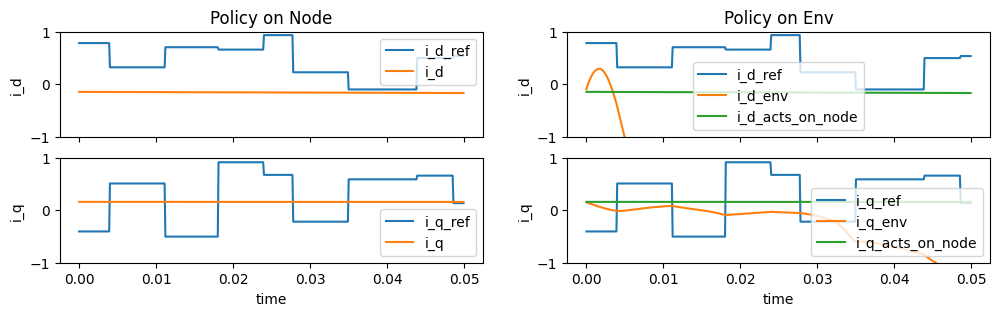

  4%|▍         | 100/2500 [00:50<14:54,  2.68it/s] 

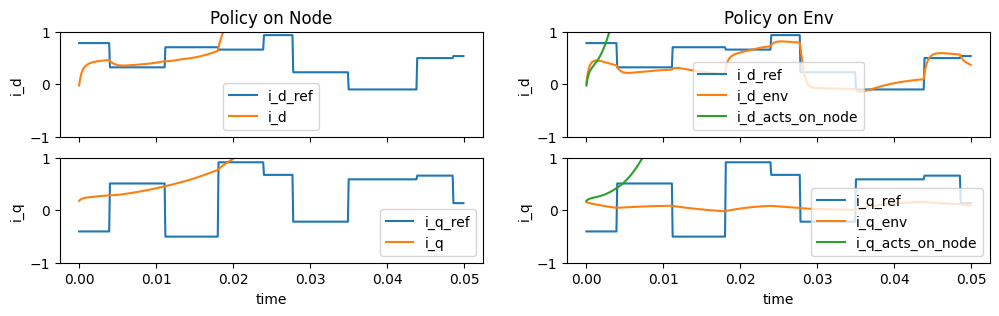

  8%|▊         | 200/2500 [01:27<13:49,  2.77it/s]

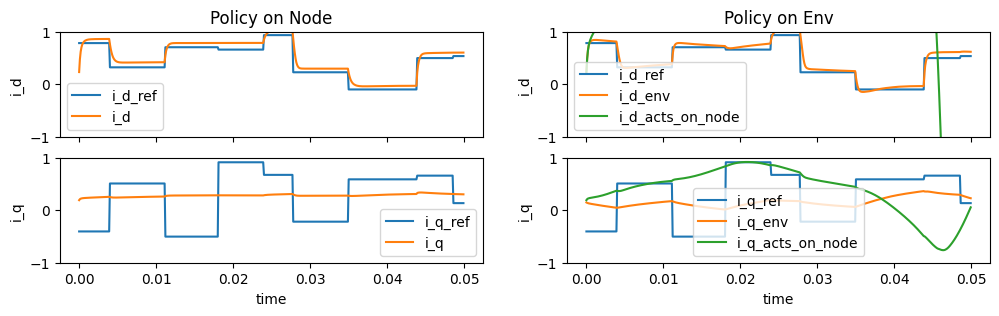

 12%|█▏        | 300/2500 [02:05<13:30,  2.71it/s]

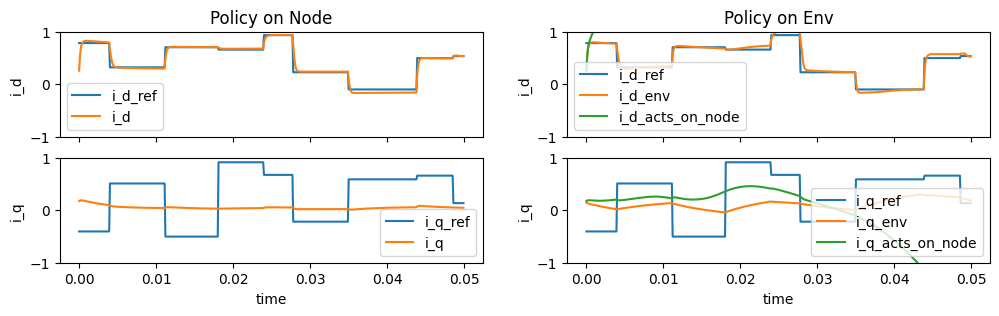

 16%|█▌        | 400/2500 [02:42<13:56,  2.51it/s]

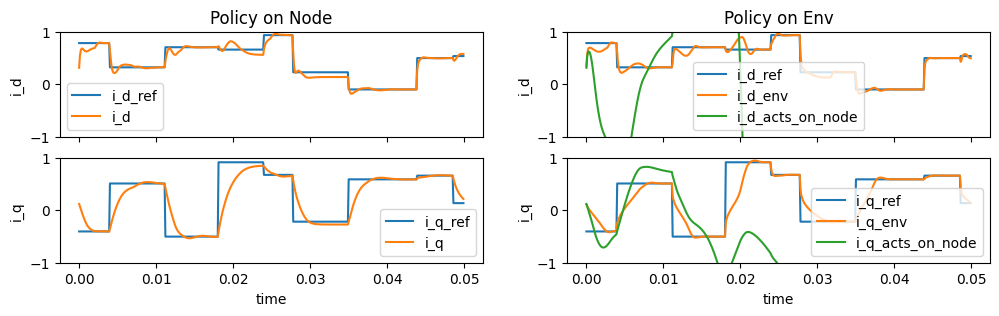

 20%|██        | 500/2500 [03:20<12:10,  2.74it/s]

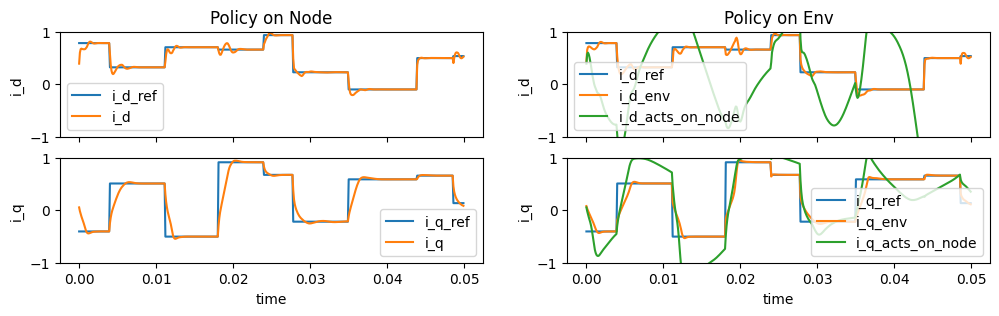

 24%|██▍       | 600/2500 [03:57<11:32,  2.74it/s]

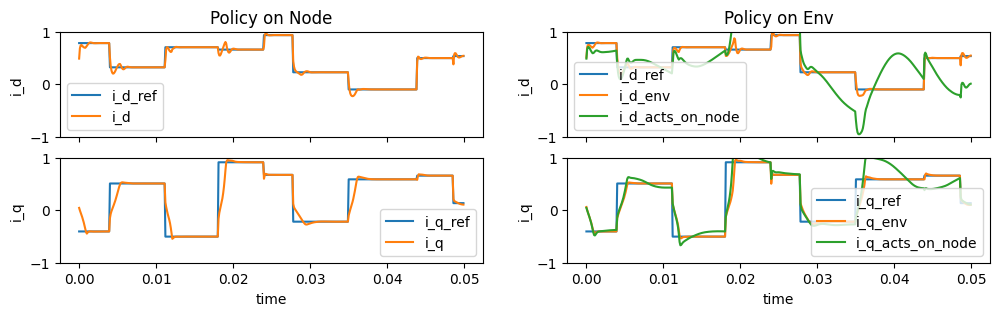

 28%|██▊       | 700/2500 [04:34<10:53,  2.76it/s]

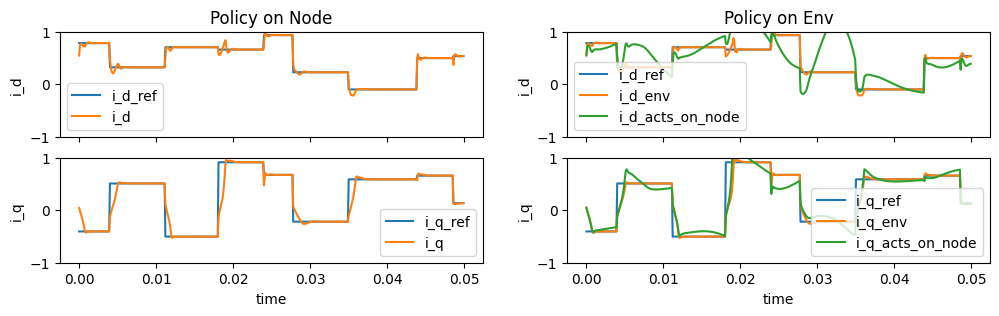

 32%|███▏      | 800/2500 [05:11<10:25,  2.72it/s]

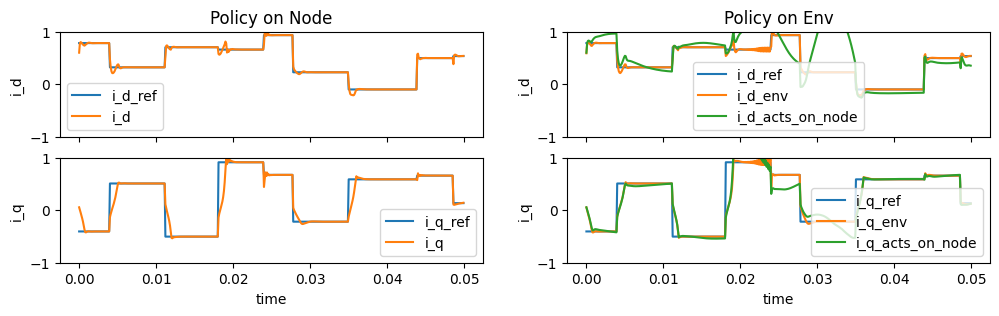

 36%|███▌      | 900/2500 [05:49<09:30,  2.81it/s]

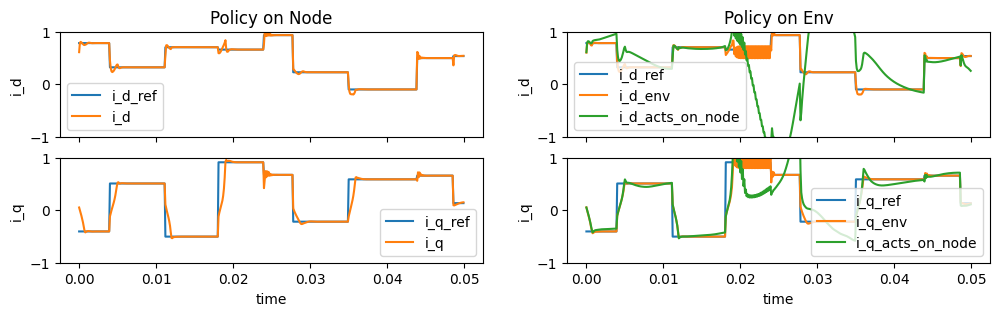

 40%|████      | 1000/2500 [06:25<08:58,  2.79it/s]

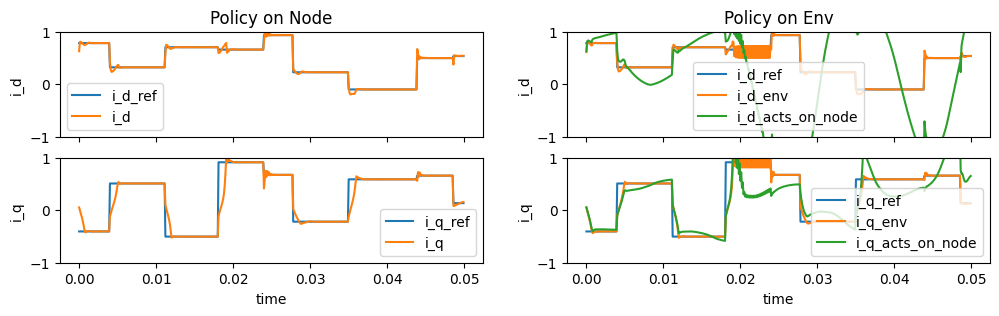

 44%|████▍     | 1100/2500 [07:02<08:26,  2.76it/s]

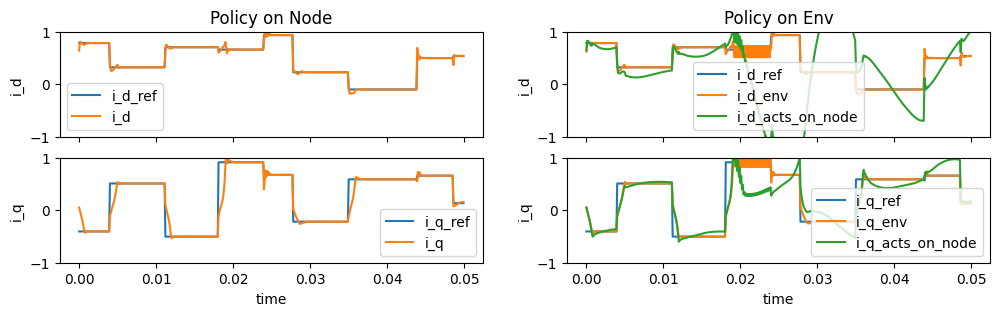

 48%|████▊     | 1200/2500 [07:39<07:45,  2.79it/s]

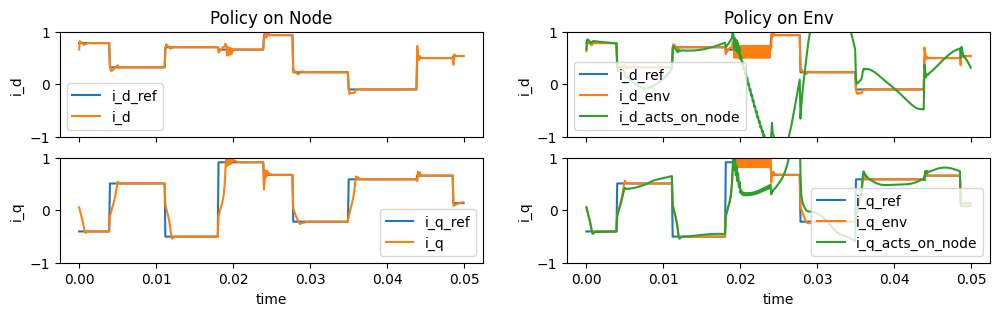

 52%|█████▏    | 1300/2500 [08:18<08:09,  2.45it/s]

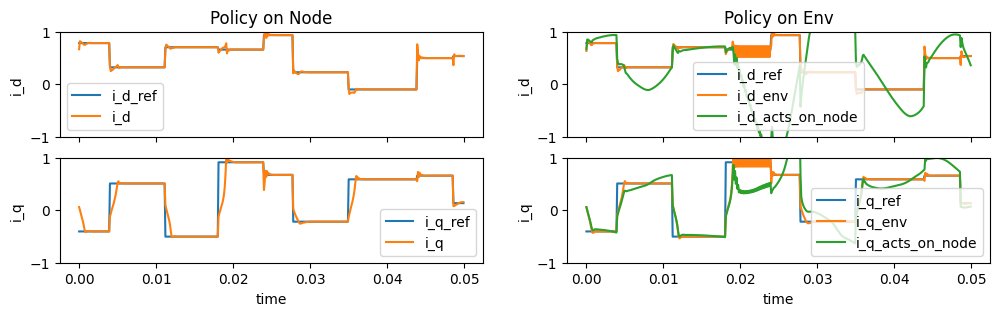

 56%|█████▌    | 1400/2500 [08:55<06:38,  2.76it/s]

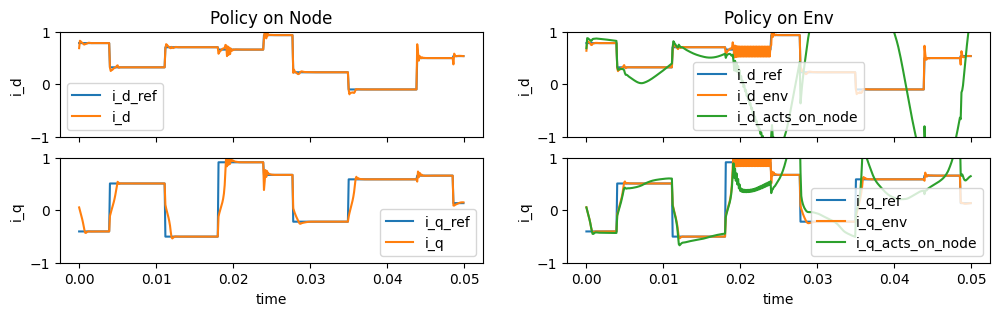

 60%|██████    | 1500/2500 [09:32<06:13,  2.68it/s]

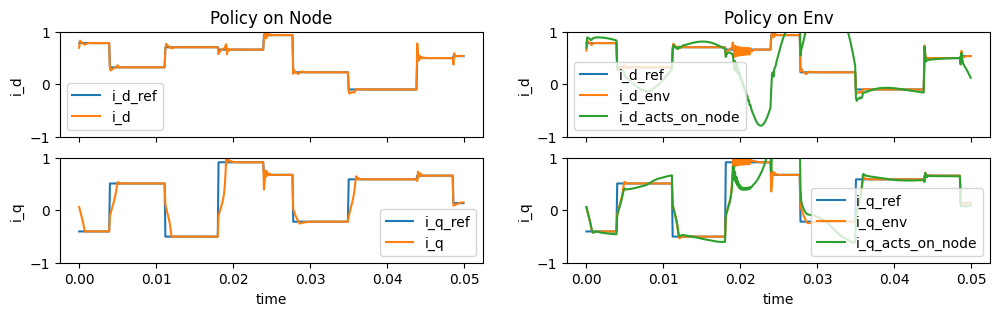

 64%|██████▍   | 1600/2500 [10:10<05:57,  2.52it/s]

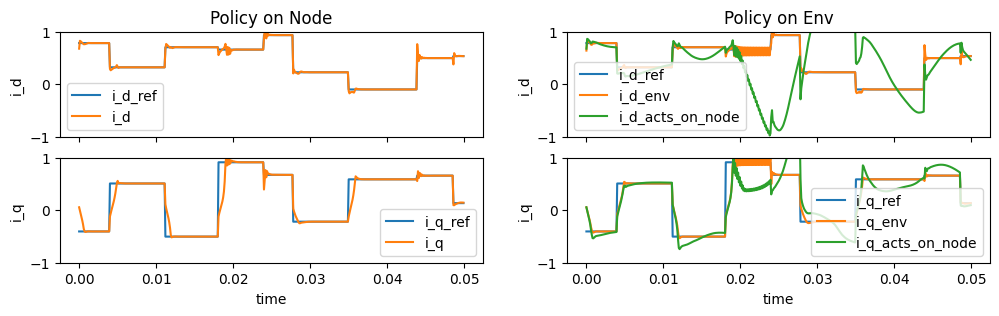

 68%|██████▊   | 1700/2500 [10:48<04:56,  2.70it/s]

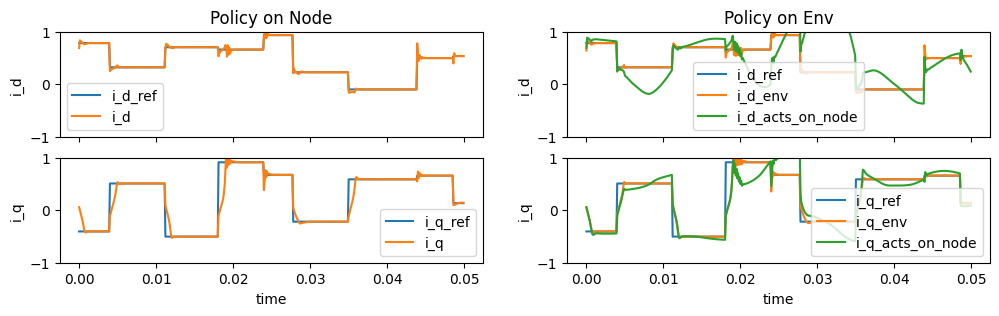

 72%|███████▏  | 1800/2500 [11:25<04:09,  2.80it/s]

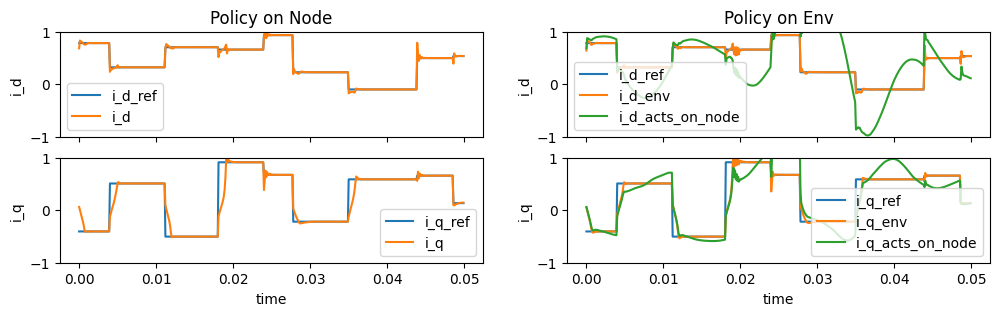

 76%|███████▌  | 1900/2500 [12:03<03:36,  2.77it/s]

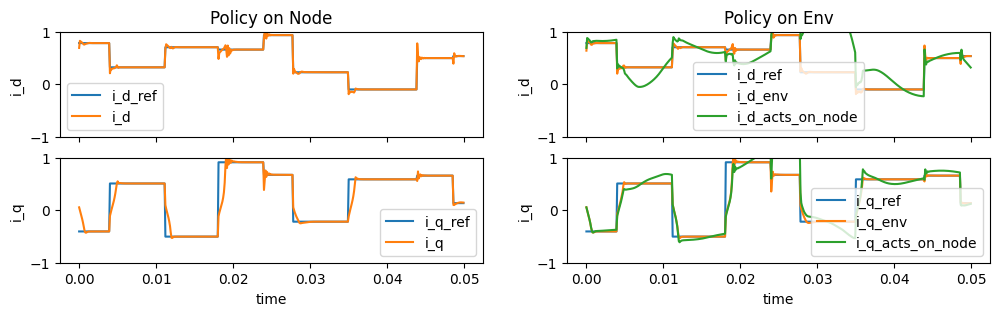

 80%|████████  | 2000/2500 [12:40<03:05,  2.70it/s]

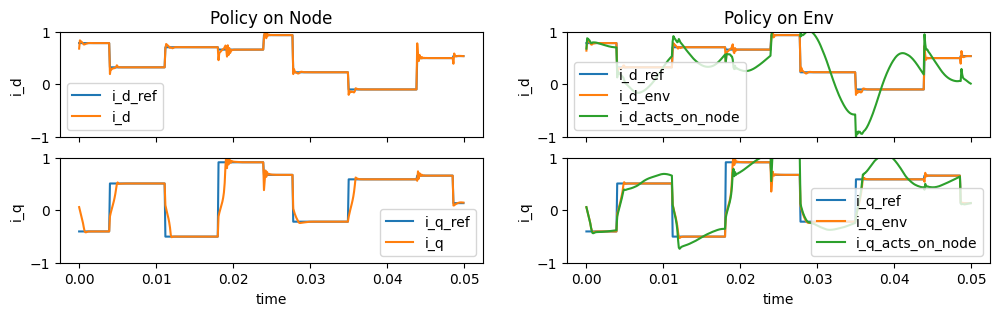

 84%|████████▍ | 2100/2500 [13:18<02:27,  2.72it/s]

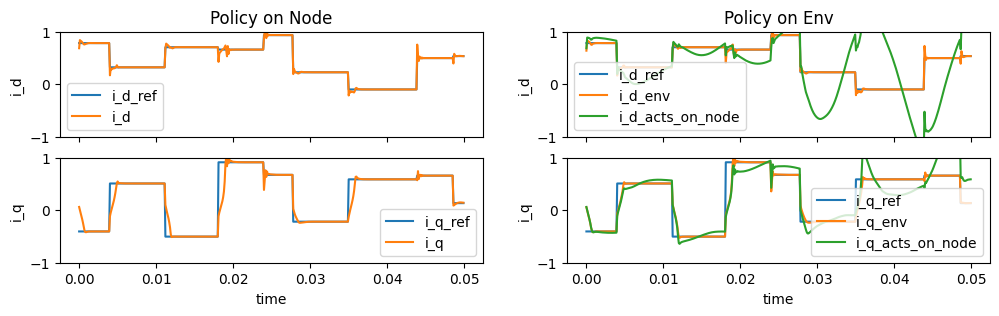

 88%|████████▊ | 2200/2500 [13:55<01:50,  2.72it/s]

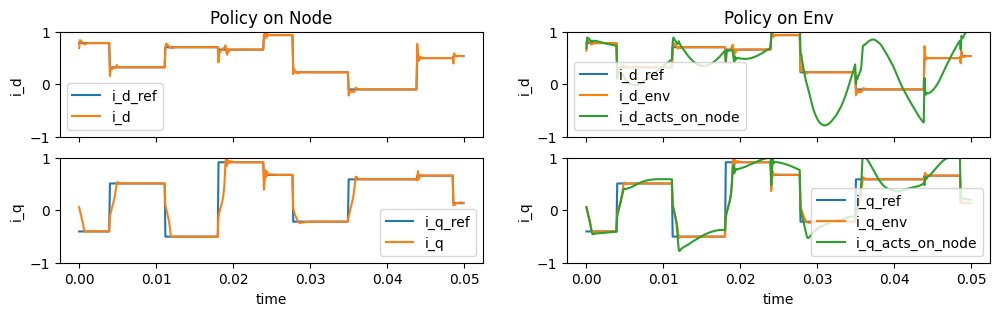

 92%|█████████▏| 2300/2500 [14:31<01:12,  2.77it/s]

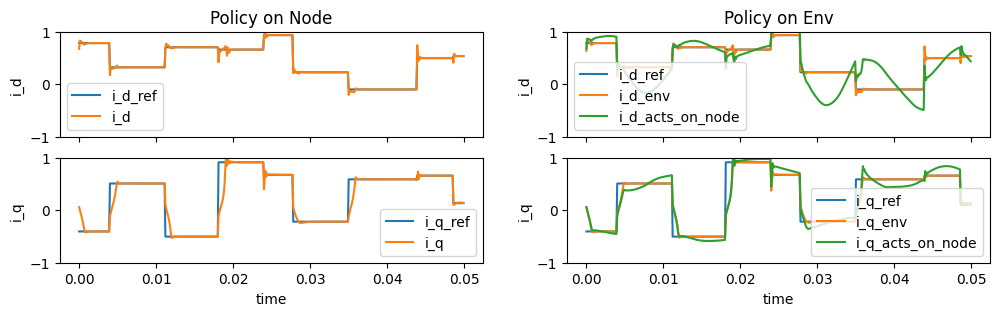

 96%|█████████▌| 2400/2500 [15:07<00:35,  2.80it/s]

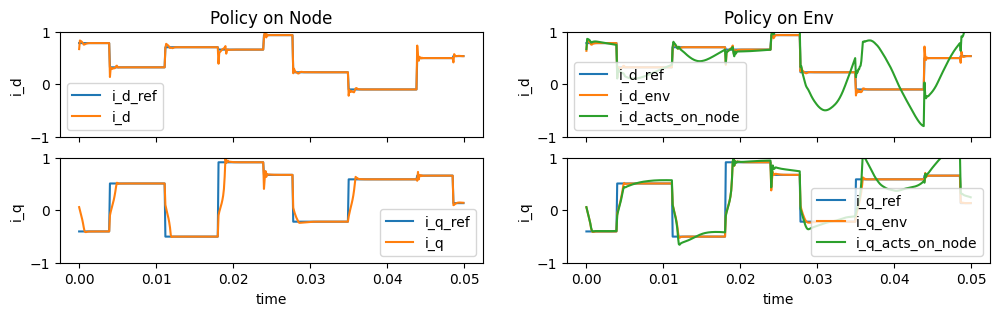

100%|██████████| 2500/2500 [15:44<00:00,  2.65it/s]


In [16]:
policy_state, policy_opt_state, node_state, node_opt_state, key, policy_losses, node_losses=trainer.fit_policy_and_env(policy,motor_env,node,motor_env.tau,featurize_node,keys,opt_state,optimizer_node,node_opt_state,val_data_gen_sin,100)

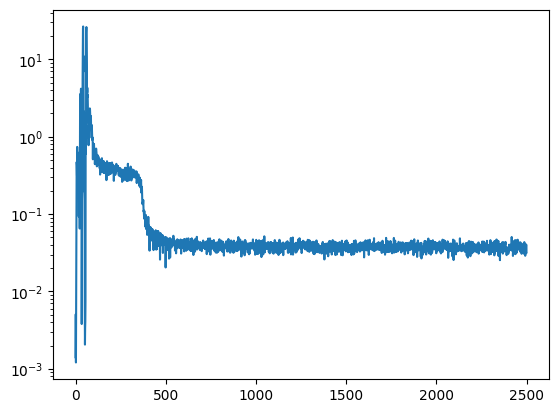

In [17]:
plt.plot(policy_losses)
plt.yscale("log")

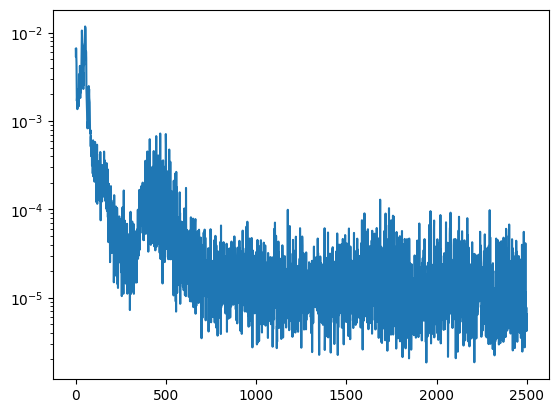

In [18]:
plt.plot(node_losses)
plt.yscale("log")

In [19]:
from utils.evaluation import steps_eval

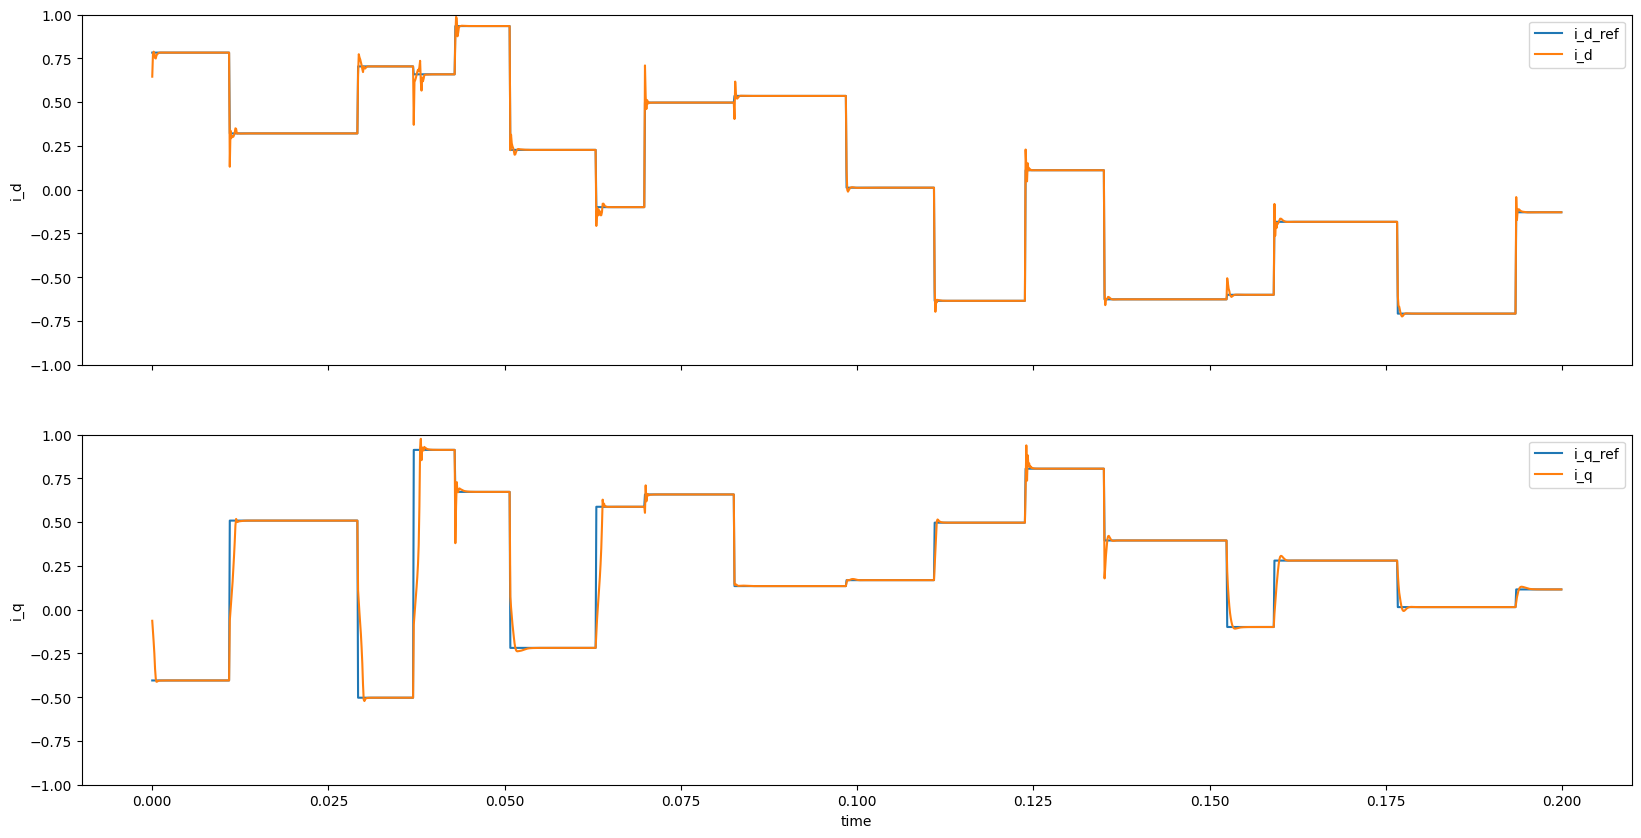

In [20]:
obs,obs_ref,acts=steps_eval(motor_env,reset,policy_state,featurize,jax.random.PRNGKey(2),2000)